In [7]:
# PARAMS:
IN_FILENAME = '../data_src/sp500.csv'
OUT_FILENAME = '../data_clean/sp500.csv'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [2]:
!lsb_release -a
!pwd
!python -V
!which python
# --- EXPECT:
# No LSB modules are available.
# Distributor ID:	Ubuntu
# Description:	Ubuntu 18.04.1 LTS
# Release:	18.04
# Codename:	bionic
# /data/learn/fucap/data_cleanup
# Python 2.7.15 :: Anaconda, Inc.
# /home/neuronq/miniconda3/envs/fucap/bin/python

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.1 LTS
Release:	18.04
Codename:	bionic
/data/learn/fucap/data_cleanup
Python 2.7.15 :: Anaconda, Inc.
/home/neuronq/miniconda3/envs/fucap/bin/python


In [3]:
# autoreload
%load_ext autoreload
%autoreload 1

# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [4]:
import os
import sys
from datetime import datetime
import datetime as dtm
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

# add project dir to import path
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

%aimport lib.visualization
%aimport lib.helpers
from lib.visualization import simple_plot
import lib.helpers as helpers

### Sources
https://www.investing.com/indices/us-spx-500-historical-data
(Same data will be returned by Bitstamp API.)

In [5]:
def fill_missing(df, inplace=False):
    if not inplace:
        df = df.copy()

    df['missing'] = 0

    from_dt = df.index.values[0]
    to_dt = df.index.values[-1]
    delta = np.timedelta64(1, 'D')
    dt = to_dt - delta
    
    empty = [np.nan] * len(df.columns)
    empty[-1] = 1

    while dt > from_dt:
        if np.is_busday(dt.astype('datetime64[D]')):
            if dt not in df.index:
                df.loc[dt] = empty
        dt -= delta
    
    df.sort_index(inplace=True)
    
    df.fillna(method='ffill', inplace=True)
    
    return df

In [8]:
data = pd.read_csv(IN_FILENAME)
print('> size:', len(data))
dd(data.head())
dd(data.tail())

> size: 933


,Date,Price,Open,High,Low,Vol.,Change %
0,"Oct 12, 2018","2,767.13","2,770.54","2,775.77","2,729.44",-,1.42%
1,"Oct 11, 2018","2,728.37","2,776.87","2,795.14","2,710.51",-,-2.06%
2,"Oct 10, 2018","2,785.68","2,873.90","2,874.02","2,784.86",-,-3.29%
3,"Oct 09, 2018","2,880.34","2,882.51","2,894.83","2,874.27",-,-0.14%
4,"Oct 08, 2018","2,884.43","2,877.53","2,889.45","2,862.08",-,-0.04%


,Date,Price,Open,High,Low,Vol.,Change %
928,"Feb 06, 2015","2,055.47","2,062.28","2,072.40","2,049.97",-,-0.34%
929,"Feb 05, 2015","2,062.52","2,043.45","2,063.55","2,043.45",-,1.03%
930,"Feb 04, 2015","2,041.51","2,048.86","2,054.74","2,036.72",-,-0.42%
931,"Feb 03, 2015","2,050.03","2,022.71","2,050.30","2,022.71",-,1.44%
932,"Feb 02, 2015","2,020.85","1,996.67","2,021.66","1,980.90",-,1.30%


In [10]:
data['datetime'] = pd.to_datetime(data['Date'])
data.set_index('datetime', inplace=True)
data.drop(['Date'], axis=1, inplace=True)
data.head(2)

,Price,Open,High,Low,Vol.,Change %
datetime,,,,,,
2018-10-12,"2,767.13","2,770.54","2,775.77","2,729.44",-,1.42%
2018-10-11,"2,728.37","2,776.87","2,795.14","2,710.51",-,-2.06%


In [11]:
data.rename(str.lower, axis='columns', inplace=True)
data.rename({'price': 'close', 'vol.': 'volume'}, axis='columns', inplace=True)
data.drop(['change %'], axis=1, inplace=True)
data.head(2)

,close,open,high,low,volume
datetime,,,,,
2018-10-12,"2,767.13","2,770.54","2,775.77","2,729.44",-
2018-10-11,"2,728.37","2,776.87","2,795.14","2,710.51",-


In [12]:
data['volume'] = data['volume'].str.replace('K', '').replace('-', 'nan').astype(float)
dd(data.head(2))
data.dtypes

,close,open,high,low,volume
datetime,,,,,
2018-10-12,"2,767.13","2,770.54","2,775.77","2,729.44",NaN
2018-10-11,"2,728.37","2,776.87","2,795.14","2,710.51",NaN


close      object
open       object
high       object
low        object
volume    float64
dtype: object

In [13]:
data['close'] = data['close'].str.replace(',', '').astype(float)

In [14]:
data['open'] = data['open'].str.replace(',', '').astype(float)

In [15]:
data['high'] = data['high'].str.replace(',', '').astype(float)

In [16]:
data['low'] = data['low'].str.replace(',', '').astype(float)

In [17]:
data.dtypes

close     float64
open      float64
high      float64
low       float64
volume    float64
dtype: object

In [18]:
data.head(2)

,close,open,high,low,volume
datetime,,,,,
2018-10-12,2767.13,2770.54,2775.77,2729.44,NaN
2018-10-11,2728.37,2776.87,2795.14,2710.51,NaN


In [19]:
fill_missing(data, inplace=True)
print('Missing:', int(data['missing'].sum()))
# EXPECT: Missing: 0

Missing: 0


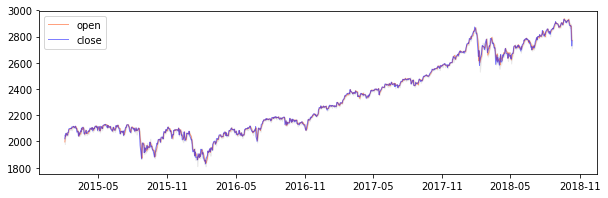

In [20]:
simple_plot(data, show_xlabels=False)

--- Last 6 M:


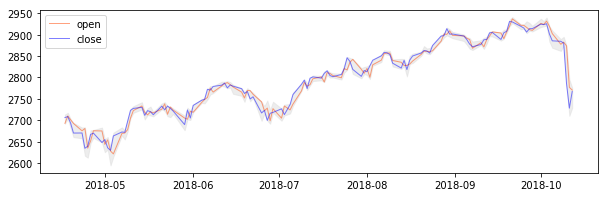

In [21]:
print('--- Last 6 M:')
simple_plot(
    data[datetime.today() - dtm.timedelta(days=6 * 30):],
    show_xlabels=False)

In [22]:
data.to_csv(OUT_FILENAME)